#1. 환경준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install langchain langchain-community langchain-openai chromadb tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.3 MB/s eta 0:00:0

In [3]:
!pip install langchain openai langchain-huggingface langchain-core huggingface_hub -q

In [4]:
import pandas as pd
import numpy as np
import os
import openai
from langchain.document_loaders import PyMuPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

In [5]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/langchain/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

#2. Vector DB 구성

## Loader

#### 1) TextLoader

- LangChain에서 가장 기본적인 데이터 로더 중 하나
- 일반적인 텍스트 파일(.txt)에서 데이터를 불러오는 역할
- txt 파일을 읽고, 이를 LangChain에서 사용할 수 있는 문서 객체(Document)로 변환

In [8]:
from langchain.document_loaders import TextLoader

# 텍스트 파일 경로 지정
file_path = "인사관리규정.txt"

# TextLoader를 이용하여 문서 로드
loader = TextLoader(path+file_path)
documents = loader.load()

# 로드된 문서 출력
print(documents)

[Document(metadata={'source': '/content/drive/MyDrive/langchain/인사관리규정.txt'}, page_content='인사관리규정\n\n제1장 총칙\n\n제1조【목적】 \n이 규정은 당사 직원에 적용할 인사관리의 기본기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다. \n\n제2조【적용범위】 \n직원의 인사에 관하여 다른 규정에 특별히 정한 것을 제외하고는 이 규정에 따른다. \n\n제3조【직원의 구분】 \n회사의 직원은 간부직, 일반직, 별정직, 기능직, 임시직, 일용직 직원으로 구분한다.\n\n제4조【직급의 구분】 \n사원의 직급은 1급 : 부장, 2급 : 차장, 3급 : 과장, 4급 : 대리, 5급 : 주임, 6급 : 대졸사원, 7급 : 고졸사원 등으로 구분하며 동일직급에서 갑, 을, 병으로 세분할 수 있다.\n\n제2장 인사위원회\n\n제5조【인사위원회】 \n①직원의 인사에 관한 사항을 심의하기 위하여 본사에 인사위원회를 둔다. \n②인사위원회의 구성은 위원장을 포함하여 ○인 이상 ○인 이내로 하되, 위원장 및 위원은 사장이 필요시에 임명하며, 간사는 인사담당부서장이 된다. \n③인사위원회의 설치 및 운영에 관한 세부사항은 인사위원회 규정에서 따로 정한다.\n\n제6조【인사위원회의 기능】 \n인사위원회는 다음 각 호의 사항을 심의, 의결한다.\n1. 인사제도의 수립, 변경 등에 관한 사항 및 인사관련 중요기본방침에 관한 사항\n2. 직원의 채용, 임명, 승진, 표창, 징계, 해고 관련사항\n3. 다른 규정에서 위임된 사항\n4. 기타 사장이 필요하다고 인정하는 사항\n\n제3장 채용과 시험\n\n제7조【신규채용】 \n직원의 신규채용은 공개경쟁시험을 원칙으로 하되 필요한 경우 특별 채용할 수도 있다. \n\n제8조【임용권자】 \n직원에 대한 임용권 일체는 사장이 가지되 필요한 경우 그 일부를 하위자에게 위임할 수 있다.\n\n제9조【채용결격사유】 \n다음 각 호에 해당하는 자는 직원

In [9]:
print(type(documents))
print(len(documents))
print(type(documents[0]))

<class 'list'>
1
<class 'langchain_core.documents.base.Document'>


In [10]:
documents[0].page_content[:1000]

'인사관리규정\n\n제1장 총칙\n\n제1조【목적】 \n이 규정은 당사 직원에 적용할 인사관리의 기본기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다. \n\n제2조【적용범위】 \n직원의 인사에 관하여 다른 규정에 특별히 정한 것을 제외하고는 이 규정에 따른다. \n\n제3조【직원의 구분】 \n회사의 직원은 간부직, 일반직, 별정직, 기능직, 임시직, 일용직 직원으로 구분한다.\n\n제4조【직급의 구분】 \n사원의 직급은 1급 : 부장, 2급 : 차장, 3급 : 과장, 4급 : 대리, 5급 : 주임, 6급 : 대졸사원, 7급 : 고졸사원 등으로 구분하며 동일직급에서 갑, 을, 병으로 세분할 수 있다.\n\n제2장 인사위원회\n\n제5조【인사위원회】 \n①직원의 인사에 관한 사항을 심의하기 위하여 본사에 인사위원회를 둔다. \n②인사위원회의 구성은 위원장을 포함하여 ○인 이상 ○인 이내로 하되, 위원장 및 위원은 사장이 필요시에 임명하며, 간사는 인사담당부서장이 된다. \n③인사위원회의 설치 및 운영에 관한 세부사항은 인사위원회 규정에서 따로 정한다.\n\n제6조【인사위원회의 기능】 \n인사위원회는 다음 각 호의 사항을 심의, 의결한다.\n1. 인사제도의 수립, 변경 등에 관한 사항 및 인사관련 중요기본방침에 관한 사항\n2. 직원의 채용, 임명, 승진, 표창, 징계, 해고 관련사항\n3. 다른 규정에서 위임된 사항\n4. 기타 사장이 필요하다고 인정하는 사항\n\n제3장 채용과 시험\n\n제7조【신규채용】 \n직원의 신규채용은 공개경쟁시험을 원칙으로 하되 필요한 경우 특별 채용할 수도 있다. \n\n제8조【임용권자】 \n직원에 대한 임용권 일체는 사장이 가지되 필요한 경우 그 일부를 하위자에게 위임할 수 있다.\n\n제9조【채용결격사유】 \n다음 각 호에 해당하는 자는 직원으로 채용하여서는 아니된다.\n 1. 금치산자 또는 한정치산자\n 2. 파산된 자로서 복권되지 아니한 자\n 3. 금고이상의 형을 받고 그 집행이 종료되거나 집행을

#### 2) Document

- LangChain에서 텍스트 데이터(문서)를 구조적으로 표현하는 기본 단위
- 주요 속성
    - metadata : 문서의 출처, 태그, 카테고리 등의 부가 정보
    - page_content : 문서의 실제 텍스트 내용
- Loader로 로딩한 후 저장하거나, 직접 Document 생성 가능


In [20]:
from langchain.schema import Document

doc = Document(
    page_content="이것은 LangChain의 Document 객체 예제입니다.",
    metadata={"source": "sample.txt", "category": "example"}
)
doc

Document(metadata={'source': 'sample.txt', 'category': 'example'}, page_content='이것은 LangChain의 Document 객체 예제입니다.')

In [21]:
doc.metadata

{'source': 'sample.txt', 'category': 'example'}

In [22]:
doc.page_content

'이것은 LangChain의 Document 객체 예제입니다.'

In [11]:
text = documents[0].page_content
text

'인사관리규정\n\n제1장 총칙\n\n제1조【목적】 \n이 규정은 당사 직원에 적용할 인사관리의 기본기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다. \n\n제2조【적용범위】 \n직원의 인사에 관하여 다른 규정에 특별히 정한 것을 제외하고는 이 규정에 따른다. \n\n제3조【직원의 구분】 \n회사의 직원은 간부직, 일반직, 별정직, 기능직, 임시직, 일용직 직원으로 구분한다.\n\n제4조【직급의 구분】 \n사원의 직급은 1급 : 부장, 2급 : 차장, 3급 : 과장, 4급 : 대리, 5급 : 주임, 6급 : 대졸사원, 7급 : 고졸사원 등으로 구분하며 동일직급에서 갑, 을, 병으로 세분할 수 있다.\n\n제2장 인사위원회\n\n제5조【인사위원회】 \n①직원의 인사에 관한 사항을 심의하기 위하여 본사에 인사위원회를 둔다. \n②인사위원회의 구성은 위원장을 포함하여 ○인 이상 ○인 이내로 하되, 위원장 및 위원은 사장이 필요시에 임명하며, 간사는 인사담당부서장이 된다. \n③인사위원회의 설치 및 운영에 관한 세부사항은 인사위원회 규정에서 따로 정한다.\n\n제6조【인사위원회의 기능】 \n인사위원회는 다음 각 호의 사항을 심의, 의결한다.\n1. 인사제도의 수립, 변경 등에 관한 사항 및 인사관련 중요기본방침에 관한 사항\n2. 직원의 채용, 임명, 승진, 표창, 징계, 해고 관련사항\n3. 다른 규정에서 위임된 사항\n4. 기타 사장이 필요하다고 인정하는 사항\n\n제3장 채용과 시험\n\n제7조【신규채용】 \n직원의 신규채용은 공개경쟁시험을 원칙으로 하되 필요한 경우 특별 채용할 수도 있다. \n\n제8조【임용권자】 \n직원에 대한 임용권 일체는 사장이 가지되 필요한 경우 그 일부를 하위자에게 위임할 수 있다.\n\n제9조【채용결격사유】 \n다음 각 호에 해당하는 자는 직원으로 채용하여서는 아니된다.\n 1. 금치산자 또는 한정치산자\n 2. 파산된 자로서 복권되지 아니한 자\n 3. 금고이상의 형을 받고 그 집행이 종료되거나 집행을

### (2) Splitter

- 긴 문서를 작은 단위인 청크(chunk)로 나누는 텍스트 분리 도구
    - 텍스트를 분리하는 작업 : 청킹(chunking)
        - LLM 모델의 입력 토큰의 개수가 정해져 있기 때문
        - 텍스트가 너무 긴 경우에는 핵심 정보 이외에 불필요한 정보들이 많이 포함  RAG 품질 저하 요인
        - 핵심 정보가 유지될 수 있는 적절한 크기로 나누는 것이 매우 중요
        
**분할시 고려사항**
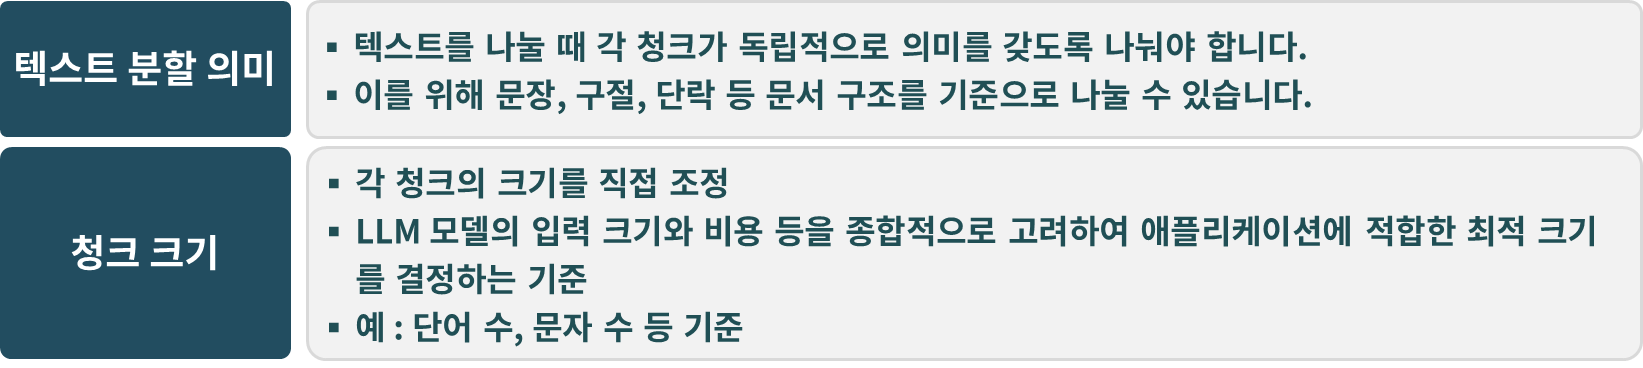

In [12]:
from langchain.text_splitter import CharacterTextSplitter

#### 1) 글자 단위

In [ ]:
text_splitter = CharacterTextSplitter(
    chunk_size = 500,#500 글자씩 나누기
    chunk_overlap  = 100,#100글자씩 겹치기
    separator = '',   # 어떤 기준 없이 무조건 500자 단위로 나누라
)

split_texts = text_splitter.split_text(text)

# 결과 확인
for i, chunk in enumerate(split_texts[:5]):  # 처음 5개 청크만 출력
    print(f"청크 {i+1}, 길이 {len(chunk)}: {chunk}\n")

#### 2) 문장 단위

In [ ]:
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separator="."  # 문장 단위로 분할
)

split_texts = text_splitter.split_text(text)

# 결과 확인
for i, chunk in enumerate(split_texts[:5]):  # 처음 5개 청크만 출력
    print(f"청크 {i+1}, 길이 {len(chunk)}: {chunk}\n")

#### 3) 줄 바꿈 단위

In [14]:
text_splitter = CharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap  = 100,
    separator = '\n',   # \n 줄바꿈 문자 기준으로 자르기,
)

split_texts = text_splitter.split_text(text)

# 결과 확인
for i, chunk in enumerate(split_texts[:5]):  # 처음 5개 청크만 출력
    print(f"청크 {i+1}, 길이 {len(chunk)}: {chunk}\n")

청크 1, 길이 478: 인사관리규정
제1장 총칙
제1조【목적】 
이 규정은 당사 직원에 적용할 인사관리의 기본기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다. 
제2조【적용범위】 
직원의 인사에 관하여 다른 규정에 특별히 정한 것을 제외하고는 이 규정에 따른다. 
제3조【직원의 구분】 
회사의 직원은 간부직, 일반직, 별정직, 기능직, 임시직, 일용직 직원으로 구분한다.
제4조【직급의 구분】 
사원의 직급은 1급 : 부장, 2급 : 차장, 3급 : 과장, 4급 : 대리, 5급 : 주임, 6급 : 대졸사원, 7급 : 고졸사원 등으로 구분하며 동일직급에서 갑, 을, 병으로 세분할 수 있다.
제2장 인사위원회
제5조【인사위원회】 
①직원의 인사에 관한 사항을 심의하기 위하여 본사에 인사위원회를 둔다. 
②인사위원회의 구성은 위원장을 포함하여 ○인 이상 ○인 이내로 하되, 위원장 및 위원은 사장이 필요시에 임명하며, 간사는 인사담당부서장이 된다.

청크 2, 길이 492: ②인사위원회의 구성은 위원장을 포함하여 ○인 이상 ○인 이내로 하되, 위원장 및 위원은 사장이 필요시에 임명하며, 간사는 인사담당부서장이 된다. 
③인사위원회의 설치 및 운영에 관한 세부사항은 인사위원회 규정에서 따로 정한다.
제6조【인사위원회의 기능】 
인사위원회는 다음 각 호의 사항을 심의, 의결한다.
1. 인사제도의 수립, 변경 등에 관한 사항 및 인사관련 중요기본방침에 관한 사항
2. 직원의 채용, 임명, 승진, 표창, 징계, 해고 관련사항
3. 다른 규정에서 위임된 사항
4. 기타 사장이 필요하다고 인정하는 사항
제3장 채용과 시험
제7조【신규채용】 
직원의 신규채용은 공개경쟁시험을 원칙으로 하되 필요한 경우 특별 채용할 수도 있다. 
제8조【임용권자】 
직원에 대한 임용권 일체는 사장이 가지되 필요한 경우 그 일부를 하위자에게 위임할 수 있다.
제9조【채용결격사유】 
다음 각 호에 해당하는 자는 직원으로 채용하여서는 아니된다.
 1. 금치산자 또는 한정치산자

In [16]:
split_texts = text_splitter.split_text(text)

### (3) Embedding & Store

**임베딩(Embedding)**
- 텍스트 데이터를 숫자로 이루어진 벡터로 변환하는 과정.
- 이때, 의미적인 정보를 보존하도록 설계

**임베딩 목적**
- 벡터 표현을 사용하면, 텍스트 데이터를 벡터 공간 내에서 수학적으로 다룰 수 있게 됨
- 이를 통해 텍스트 간의 유사성을 계산 가능
- 텍스트 데이터를 기반으로 하는 다양한 머신러닝 및 자연어 처리 작업 수행

**임베딩 모델 사용**
- Openai : text-embedding-3-small

**벡터 저장소(Vector Store)**
- 벡터 형태로 표현된 데이터, 즉 임베딩 벡터들을 효율적으로 저장하고 검색할 수 있는 DB
- Vector DB라고 불림 (대표적인 Vector DB : Chroma, FAISS)

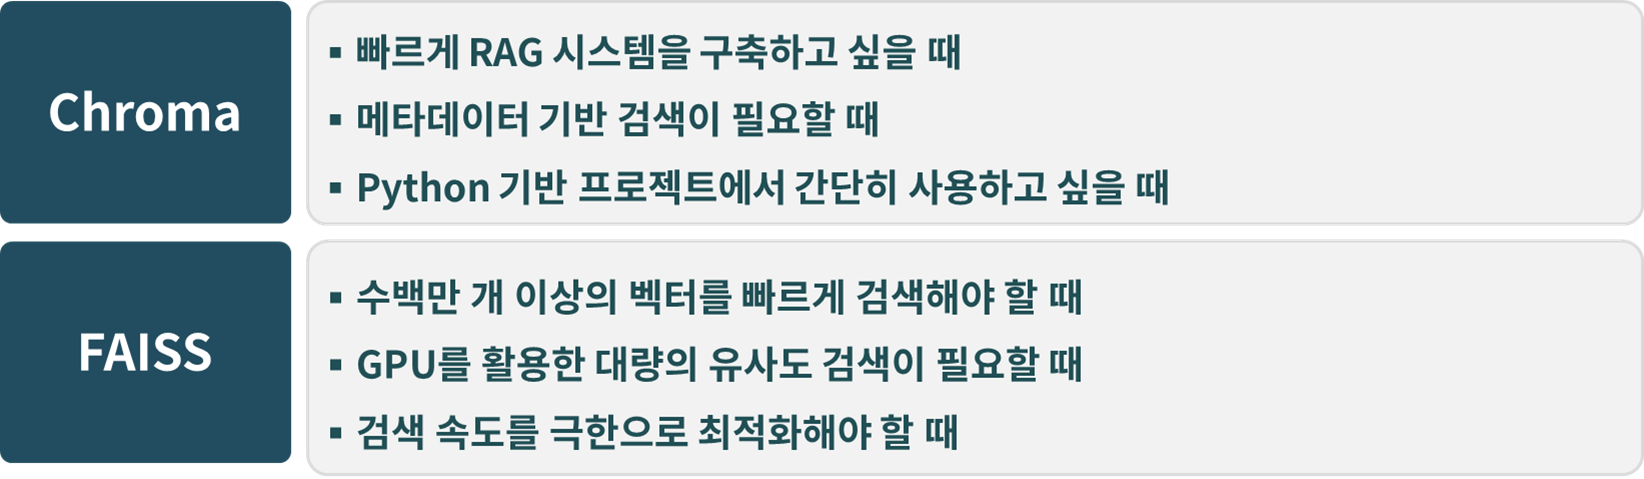



In [17]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Hugging Face 임베딩 모델 (sentence-transformers 기반)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# split_texts는 미리 준비한 텍스트 조각 리스트라고 가정
vectorstore = Chroma.from_texts(
    texts=split_texts,
    embedding=embedding_model,
    persist_directory="./chroma_db"
)

print("ChromaDB에 저장 완료!")

ChromaDB에 저장 완료!


## 3.RAG 파이프라인

* 순서
    * (1) Retriever 선언
        - Vector DB에서 사용자의 질문과 가장 유사한 문서(청크)를 검색
        - 코사인 유사도(Cosine Similarity) 기반으로 유사한 문서 검색
    * (2) llm 모델 지정
        - 검색된 문서와 함께 질문을 받아 답변 생성할 LLM 모델 지정
    * (3) 메모리 선언
        - 대화의 흐름을 유지하고, 이전 질문을 기억하여 문맥을 제공
        - 프롬프트 길이를 고려한 메모리 최적화 필요        
    * (4) 체인 함수로 엮기
        - Retriever + LLM + Memory를 하나의 체인으로 연결하여 질문-응답 시스템 완성
    

### (1) RAG 파이프라인 구축

In [18]:
# (1) 리트리버(Retriever) 생성
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# (2) GPT-4o mini 모델 설정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)

# (3) 메모리 추가 (대화 문맥 유지)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True, output_key="answer")

# (4) RAG 기반 ConversationalRetrievalChain 구성
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=False  # 검색된 문서 출력 옵션
)

### (2) RAG 파이프라인 사용

In [19]:
# 6. 질의
# 테스트 실행
query = "제 1장에 대한 내용을 알려줘"
response = qa_chain({"question": query})

# 응답 출력
print("답변:", response["answer"])

답변: **제 1장 총칙**  
(본 규정은 회사 직원에 적용되는 인사관리에 관한 기본 기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다.)

|조 | 내용 |
|---|------|
|**제1조(목적)** | 이 규정은 당사 직원에 적용할 인사관리에 관한 기본기준과 절차를 정하여 공정하고 합리적인 인사업무처리에 기여함을 목적으로 한다. |
|**제2조(적용범위)** | 직원의 인사에 관하여 다른 규정에 특별히 정한 것을 제외하고는 이 규정에 따른다. |
|**제3조(직원의 구분)** | 회사의 직원은 간부직, 일반직, 별정직, 기능직, 임시직, 일용직 직원으로 구분한다. |
|**제4조(직급의 구분)** | 사원의 직급은 <br>① 1급 : 부장 <br>② 2급 : 차장 <br>③ 3급 : 과장 <br>④ 4급 : 대리 <br>⑤ 5급 : 주임 <br>⑥ 6급 : 대졸사원 <br>⑦ 7급 : 고졸사원 등으로 구분하며, 동일 직급에서 갑, 을, 병으로 세분할 수 있다. |

이것이 제 1장(총칙) 전체의 내용입니다.
